# Сегментация клиентов онлайн-магазина подарков

Онлайн-магазин решил проанализировать своих клиентов перед проведением маркетинговой кампании для увеличения прибыли, ему необходимо сегментировать клиентов, чтобы маркетинговая кампания имела более детальный подход и была проведена с учетом следующих особенностей: покупательской способности, частоты совершения заказов, срока давности заказа. 

Таким образом, нам, как специалистам Data Science необходимо выделить различные категории среди всех клиентов магазина: например, лояльные/перспективные/новички/спящие/ушедшие и создать алгоритм классификации по этим группам.

**Бизнес-задача:** произвести сегментацию клиентов, проинтерпретировать эти сегменты.

**Техническая задача:** построить модель кластеризации клиентов на основе их покупательской способности, частоты заказов и срока давности последней покупки, определить профиль каждого из кластеров.

**Этапы проекта:**
1. Произвести предобработку набора данных.
2. Провести разведывательный анализ данных и выявить основные закономерности.
3. Построить несколько моделей машинного обучения, решающих задачу кластеризации клиентов, определить количество кластеров и проинтерпретировать их.
4. Спроектировать процесс предсказания категории активности клиента и протестировать модель.

## 1. Знакомство с данными. 

In [233]:
import pandas as pd                         # для анализа и обработки данных
import numpy as np                          # для матричных вычислений
import matplotlib.pyplot as plt             # для визуализации данных, графическом отображении факторов и их зависимостей
import seaborn as sns                       # для визуализации данных, графическом отображении факторов и их зависимостей
from mpl_toolkits.mplot3d import Axes3D

import plotly.graph_objs as go              # для визуализации данных, графическом отображении факторов и их зависимостей
import plotly.express as px
from plotly.subplots import make_subplots

from sklearn import mixture                 # модуль гауссовских моделей смеси (поддерживаются диагональные, сферические, связанные и полные ковариальные матрицы)      
from sklearn import manifold                # модуль алгоритмов по уменьшению размерности больших многомерных нелинейной структуры данных
from sklearn.pipeline import Pipeline       # алгоритм единого автоматизированного процесса обработки, генерации, подготовки данных вместе с построением модели ML
from sklearn import preprocessing           # модуль подготовки данных для подачи их в модель
from sklearn import cluster                 # модуль алгоритмов кластеризации
from sklearn import metrics                 # метрические функции оценки качества модели
from sklearn import model_selection         # модуль иструментов разбиения данных, использования перекрестной проверки и улучшения качества моделей
from sklearn import decomposition           # модуль алгоритмов линейного уменьшения размерности даннных
from sklearn import ensemble                # модуль ансамблевых алгоритмов ML

from catboost import CatBoostClassifier     # алгоритм градиентного бустинга
import warnings 

from IPython.display import display, HTML

warnings.filterwarnings("ignore")

plt.rcParams["patch.force_edgecolor"] = True

Загразука данных:

In [234]:
url='https://drive.google.com/file/d/1Axlknf1Rd6T6UFRzWWZA_gBbfN2g9r3v/view?usp=sharing'
url='https://drive.google.com/uc?id=' + url.split('/')[-2]
data = pd.read_csv(url, encoding="ISO-8859-1", dtype={'CustomerID': str,'InvoiceID': str})
print('Data shape: {}'.format(data.shape))
data.head()
# data = pd.read_csv('data/customer_segmentation_project.csv', encoding="ISO-8859-1", dtype={'CustomerID': str,'InvoiceID': str})
# print('Data shape: {}'.format(data.shape))
# data.head()

Data shape: (541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,United Kingdom


Итак, у нас есть данные о более чем полумиллионе транзакций. Каждая из них описывается следующими признаками:

* InvoiceNo — номер счёта-фактуры (уникальный номинальный шестизначный номер, присваиваемый каждой транзакции; буква "C" в начале кода указывает на отмену транзакции);
* Stock Code — код товара (уникальное пятизначное целое число, присваиваемое каждому отдельному товару);
* Description — название товара;
* Quantity — количество каждого товара за транзакцию; 
* InvoiceDate — дата и время выставления счёта/проведения транзакции;
* UnitPrice — цена за единицу товара в фунтах стерлингов;
* CustomerID — идентификатор клиента (уникальный пятизначный номер, однозначно присваиваемый каждому клиенту);
* Country — название страны, в которой проживает клиент.

### 1.1 Анализ структуры данных.

In [235]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  object 
 7   Country      541909 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 33.1+ MB


In [236]:
# посмотрим на пропуски в данных
data.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [237]:
# посмотрим временные рамки имеющихся данных
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])
print('Период времени, представленный данными: с {} по {} '.format(data['InvoiceDate'].dt.date.min(), data['InvoiceDate'].dt.date.max()))

Период времени, представленный данными: с 2010-12-01 по 2011-12-09 


Описательная статистика датасета

In [238]:
print(data.describe().T.round(2))
print('----------------------')
print(data.describe(include='object').T)
print('----------------------')
print('Минимальная неотрицательная стоимость товара:', data[data['UnitPrice'] >= 0]['UnitPrice'].min())
print('----------------------')
print('Страны клиентов:', data['Country'].unique(), sep='\n')

              count  mean     std       min   25%   50%    75%      max
Quantity   541909.0  9.55  218.08 -80995.00  1.00  3.00  10.00  80995.0
UnitPrice  541909.0  4.61   96.76 -11062.06  1.25  2.08   4.13  38970.0
----------------------
              count unique                                 top    freq
InvoiceNo    541909  25900                              573585    1114
StockCode    541909   4070                              85123A    2313
Description  540455   4223  WHITE HANGING HEART T-LIGHT HOLDER    2369
CustomerID   406829   4372                               17841    7983
Country      541909     38                      United Kingdom  495478
----------------------
Минимальная неотрицательная стоимость товара: 0.0
----------------------
Страны клиентов:
['United Kingdom' 'France' 'Australia' 'Netherlands' 'Germany' 'Norway'
 'EIRE' 'Switzerland' 'Spain' 'Poland' 'Portugal' 'Italy' 'Belgium'
 'Lithuania' 'Japan' 'Iceland' 'Channel Islands' 'Denmark' 'Cyprus'
 'Sweden' 'Aus

***1. Мы видим отрицательную стоимость товаров, что указывает на отмену транзакции, как и отрицательное значение количества товаров.***\
***2. Товары с нулевой стоимостью, скорее всего это товары по акции, скидочные.***\
***3. Клиентами магазина являются 4372 компании или физических лиц, которые совершили за представленный год 25900 транзакций/отмены транзакций.***\
***4. Клиентами магазина являются компании из 37 стран, 91.4% из Великобритании.***\
***5. Два признака: описание товара и идентификационный номер клиента содержат пропуски.***

## 2. Предобработка и очистка данных.

### 2.1 Удаление пропусков и дубликатов.

In [239]:
# удаляем все объекты с пропусками
data.dropna(how='any', axis=0, inplace=True)
print('Число найденных дубликатов: {}'.format(data.duplicated().sum()))
# удаляем дубликаты
data.drop_duplicates(inplace=True)
data.shape[0]

Число найденных дубликатов: 5225


401604

### 2.2 Анализ отмененных транзакций
Ранее мы заметили, что в столбце с количеством товара есть отрицательные значения. Давайте разберемся, откуда они взялись. Выведем первые 5 строк таблицы, в которой столбец Quantity меньше 0.

In [240]:
negative_quantity = data[(data['Quantity']<0)]
print('Количество товаров с отрицательными значениями: {}'.format(negative_quantity.shape[0]))
negative_quantity.head()

Количество товаров с отрицательными значениями: 8872


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom


Давайте проверим, что все записи из таблицы с отрицательным количеством товара действительно являются возвратными транзакциями, в инвойсе содержится буква С. Если транзакция не является возвратом, но содержит отрицательное количество товара, это будет поводом считать её выбросом.

In [241]:
neg_invoice = negative_quantity['InvoiceNo'].str.findall(r'^C')
neg_invoice.value_counts()

[C]    8872
Name: InvoiceNo, dtype: int64

Разберёмся с возвратами подробнее. Сейчас на каждый уникальный товар заведена отдельная строка в таблице — это мешает определить общее количество возвратов.\
Чтобы подсчитать число возвратов, сначала необходимо определить, сколько уникальных товаров указано в транзакции (инвойсе) для каждой уникальной пары «клиент-заказ»:

In [242]:
# создаем таблицу: количество заказанных товаров по каждому клиенту
temp = data.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate'].count()
nb_products_per_basket = temp.rename(columns = {'InvoiceDate':'Number of products'})
nb_products_per_basket.head()

,CustomerID,InvoiceNo,Number of products
0,12346,541431,1
1,12346,C541433,1
2,12347,537626,31
3,12347,542237,29
4,12347,549222,24


В созданной таблице nb_products_per_basket сформируем признак отмены заказа (order_canceled): он равен 1, если транзакция является возвратом, и 0 — в противном случае.

In [243]:
nb_products_per_basket['order_canceled'] = nb_products_per_basket['InvoiceNo'].replace(regex={r'^C': 1, r'\d+': 0})
print('Процент уникальных заказов, для которых отменена транзакция (произведен возврат): {} %'\
      .format(round(nb_products_per_basket['order_canceled'].sum()/len(nb_products_per_basket)*100)))

Процент уникальных заказов, для которых отменена транзакция (произведен возврат): 16 %


In [244]:
nb_products_per_basket['order_canceled'].value_counts()

0    18536
1     3654
Name: order_canceled, dtype: int64

***То есть, из общего количества заказов 22190 (после удаления пропусков и дубликатов) отменены 3654 транзакций.***

Изучим отмененные заказы:

In [245]:
nb_products_per_basket[nb_products_per_basket['order_canceled']==1].head()

,CustomerID,InvoiceNo,Number of products,order_canceled
1,12346,C541433,1,1
23,12352,C545329,2,1
24,12352,C545330,1,1
25,12352,C547388,7,1
39,12359,C549955,2,1


Возьмем все транзакции первого клиента с идентификатором 12346:

In [246]:
data[data['CustomerID'] == '12346']

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346,United Kingdom
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,2011-01-18 10:17:00,1.04,12346,United Kingdom


*Отмененная транзакция и транзакция: совпадает код товара и значения количества противоположны.*

**Выдвигаем гипотезу: для каждой отменённой транзакции существует её аналог с тем же кодом товара, идентификатором клиента и противоположным значением количества товара.**

In [247]:
for index, col in negative_quantity.iterrows():
    if data[(data['CustomerID']==col['CustomerID'])&(data['Quantity']==-col['Quantity'])&\
            (data['StockCode']==col['StockCode'])].shape[0]==0:
        print(col)
        break

InvoiceNo                  C536379
StockCode                        D
Description               Discount
Quantity                        -1
InvoiceDate    2010-12-01 09:41:00
UnitPrice                     27.5
CustomerID                   14527
Country             United Kingdom
Name: 141, dtype: object


Итак, гипотеза оказалось неверна, первое несовпадение - клиент с идентификатором 14527:

In [248]:
data[data['CustomerID'] == '14527'].head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527,United Kingdom
8963,537159,22112,CHOCOLATE HOT WATER BOTTLE,6,2010-12-05 13:17:00,4.95,14527,United Kingdom
8964,537159,22111,SCOTTIE DOG HOT WATER BOTTLE,1,2010-12-05 13:17:00,4.95,14527,United Kingdom
8965,537159,21479,WHITE SKULL HOT WATER BOTTLE,1,2010-12-05 13:17:00,3.75,14527,United Kingdom
8966,537159,22114,HOT WATER BOTTLE TEA AND SYMPATHY,6,2010-12-05 13:17:00,3.95,14527,United Kingdom


Первая строка содержит заказ C536379 с признаком отмены — противоположных ему аналогов по количеству товаров нет. Данный товар обозначен как товар со скидкой (StockCode - D), и, по-видимому, для таких транзакций нет аналогов с положительным числом товаров в заказе. Учтём это наблюдение на будущее.

**Выдвигаем новую гипотезу: для каждой отменённой транзакции в базе данных существует её аналог с тем же кодом товара, идентификатором клиента и противоположным значением количества товара, если на товар не распространяются скидки.**

In [249]:
negative_quantity_noD = negative_quantity[negative_quantity['StockCode'] != 'D']
for index, col in negative_quantity_noD.iterrows():
    if data[(data['CustomerID']==col['CustomerID'])&(data['Quantity']==-col['Quantity'])&\
            (data['Description']==col['Description'])].shape[0]==0:
        print(col)
        break

InvoiceNo                              C536383
StockCode                               35004C
Description    SET OF 3 COLOURED  FLYING DUCKS
Quantity                                    -1
InvoiceDate                2010-12-01 09:49:00
UnitPrice                                 4.65
CustomerID                               15311
Country                         United Kingdom
Name: 154, dtype: object


Вновь наша гипотеза оказалась неверна. Посмотрим транзакции, относящиеся к клиенту с идентификатором 15311 и товаром под кодом 35004C:

In [250]:
data[(data['CustomerID'] == '15311') & (data['StockCode'] == '35004C')]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311,United Kingdom
9200,537195,35004C,SET OF 3 COLOURED FLYING DUCKS,12,2010-12-05 13:55:00,4.65,15311,United Kingdom
18196,C537805,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-08 13:18:00,4.65,15311,United Kingdom
28630,538651,35004C,SET OF 3 COLOURED FLYING DUCKS,12,2010-12-13 15:07:00,4.65,15311,United Kingdom
39381,C539640,35004C,SET OF 3 COLOURED FLYING DUCKS,-3,2010-12-20 15:27:00,4.65,15311,United Kingdom
44157,540157,35004C,SET OF 3 COLOURED FLYING DUCKS,12,2011-01-05 11:41:00,4.65,15311,United Kingdom
59542,541293,35004C,SET OF 3 COLOURED FLYING DUCKS,12,2011-01-17 13:39:00,4.65,15311,United Kingdom
78333,C542866,35004C,SET OF 3 COLOURED FLYING DUCKS,-2,2011-02-01 12:14:00,4.65,15311,United Kingdom


* На первой строке мы видим заказ с отменой (номер заказа начинается с символа C в инвойсе). Однако возникает вопрос: на какой заказ пришла эта отмена, ведь более ранних записей о транзакциях, связанных с этим клиентом, нет.
Ответ состоит в том, что заказ на покупку данного товара от клиента поступил раньше декабря 2010 года, а этих данных в нашей таблице нет. Это очень популярная проблема, которая возникает практически при любой работе с транзакциями: есть только фрагмент из общих данных, однако неизвестно, что предшествовало этому фрагменту.

* По двум следующим строкам видно, что клиент может отменить не весь заказ, а только его часть (5 декабря клиент покупает 12 единиц товара, а 8 декабря оформляет возврат только на одну единицу товара). Мы должны принять это во внимание на будущее

***Итак, мы проанализировали все особенности отмены заказов. При сегментировании клиентов мы будем определять их покупательскую способность, а для этого учитывать возвраты товаров. Поэтому создадим в данных о транзакциях признак QuantityCanceled, который будет указывать на количество возвращённого впоследствии товара для каждой транзакции.*** 

"Игнорируем" аномальные явления:
1. Отменённая транзакция не имеет противоположной (на транзакцию-возврат не нашлось ни одной транзакции на покупку).
2. Количество возвращённого товара в транзакции-возврате больше, чем количество товара, которое указано в любой из отдельных транзакций на покупку (это случай, когда клиент сделал несколько заказов одного и того же товара, а потом оформил возврат на все товары разом).

In [251]:
def get_quantity_canceled(data):
    # инициализируем нулями Series той же длины, что и столбцы таблицы
    quantity_canceled = pd.Series(np.zeros(data.shape[0]), index=data.index)    
    negative_quantity = data[(data['Quantity'] < 0)].copy()
    for index, col in negative_quantity.iterrows():
        # создаём DataFrame из всех транзакций, противоположных возвратам
        df_test = data[(data['CustomerID'] == col['CustomerID']) &
                       (data['StockCode']  == col['StockCode']) & 
                       (data['InvoiceDate'] < col['InvoiceDate']) & 
                       (data['Quantity'] > 0)].copy()
        # транзация-возврат не имеет противоположной — ничего не делаем
        if (df_test.shape[0] == 0): 
            continue
        # транзакция-возврат имеет только одну противоположную транзакцию
        # добавляем количество возвращённого товара в столбец QuantityCanceled 
        elif (df_test.shape[0] == 1): 
            index_order = df_test.index[0]
            quantity_canceled.loc[index_order] = -col['Quantity']       
        # транзакция-возврат имеет несколько противоположных транзакций
        # вносим количество возвращённого товара в столбец QuantityCanceled для той транзакции на покупку,
        # в которой количество товара > (-1) * (количество товаров в транзакции-возврате)
        elif (df_test.shape[0] > 1): 
            df_test.sort_index(axis=0 ,ascending=False, inplace = True)        
            for ind, val in df_test.iterrows():
                if val['Quantity'] < -col['Quantity']: 
                    continue
                quantity_canceled.loc[ind] = -col['Quantity']
                break    
    return quantity_canceled
# применим функцию
data['QuantityCanceled'] = get_quantity_canceled(data)
print('Суммарное количество отмененных товаров: ', data['QuantityCanceled'].sum())

Суммарное количество отмененных товаров:  245266.0


Мы создали новый признак с возвращенными товарами.\
Удалим из данных транзакции, в которых указано отрицательное количество товара.  

In [252]:
data_cleaned = data[data['Quantity']>=0]
data_cleaned.shape[0]

392732

### 2.3 Очистка данных от транзакций специальных видов
Следующая проблема — это специальные виды транзакций. Например, ранее мы уже видели, что для товаров со скидкой признак StockCode обозначен как 'D'. Проверим, бывают ли другие специальные коды.

С помощью регулярного выражения найдем транзакции со специальными кодами товаров (StockCode), которые начинаются с латинских букв (при этом коды могут содержать цифры). 

Специальные операции не характеризуют наших клиентов, поэтому такие записи со специальными транзакциями мы удалим из набора данных. 

In [253]:
codes = data_cleaned['StockCode'].str.contains(r'^[a-zA-Z]+', regex=True)
print('Виды специальных транзакций: ', data_cleaned[codes==True]['StockCode'].unique())
data_cleaned = data_cleaned[codes==False]
data_cleaned.shape

Виды специальных транзакций:  ['POST' 'C2' 'M' 'BANK CHARGES' 'PADS' 'DOT']


(391183, 9)

### 2.4 Очистка данных от транзакций с ценой за товар в 0 фунтов стерлингов.
Ранее при просмотре описательных статистик мы видели, что на некоторые товары цена равна 0. 

In [254]:
print('Количество транзакций с нулевой стоимостью: ', data_cleaned[data_cleaned['UnitPrice']==0].shape[0])
data_cleaned = data_cleaned[data_cleaned['UnitPrice'] != 0]
data_cleaned.shape[0]

Количество транзакций с нулевой стоимостью:  33


391150

***Итак, мы завершили этап подготовки данных:***
1. **Удалили все пропуски и дубликаты.**
2. **Очистили данные от "неполезной" информации: специальные транзакции и транзакции с нулевой стоимостью.**
3. **Создали новый признак с количеством товаров отмененных транзакций, все остальные операции с отрицательным количеством заказа удалили.**

## 3. Разведывательный анализ данных

Определимся с задачами:
* понять, клиенты из каких стран покупают больше и чаще;
* узнать, присутствует ли в продажах сезонность (когда покупают чаще);
* сгенерировать новые признаки, которые в дальнейшем понадобятся при формировании датасета о клиентах.

### 3.1 Распределение клиентов по странам

In [255]:
# создаем таблицу c уникальными идентификаторами клиентов
сustomer_country = data_cleaned[['CustomerID', 'Country']].drop_duplicates()
# группируем по странам и сортируем по количеству клиентов
customer_df = сustomer_country.groupby('Country')['CustomerID'].count().reset_index().sort_values(by='CustomerID')
# отобразим данные на тепловой диаграмме
fig = px.choropleth(
    customer_df,
    locations = 'Country',
    locationmode='country names',
    color = 'CustomerID',
    height = 500,
    width = 800,
    color_continuous_scale='Viridis',
    scope='europe',                               # ограничимся географией Европы
    title = 'Распределение клиентов по странам'
)
fig.update_layout(
    margin={"r":0,"t":20,"l":0,"b":20},
    title=dict(font=dict(size=20), automargin=True, xanchor='left')
    )
fig.show()

Мы видим, что по всем странам, кроме Великобритании очень небольшое или очень маленькое количество клиентов.\
Посмотрим на распределение, исключая Великобританию.

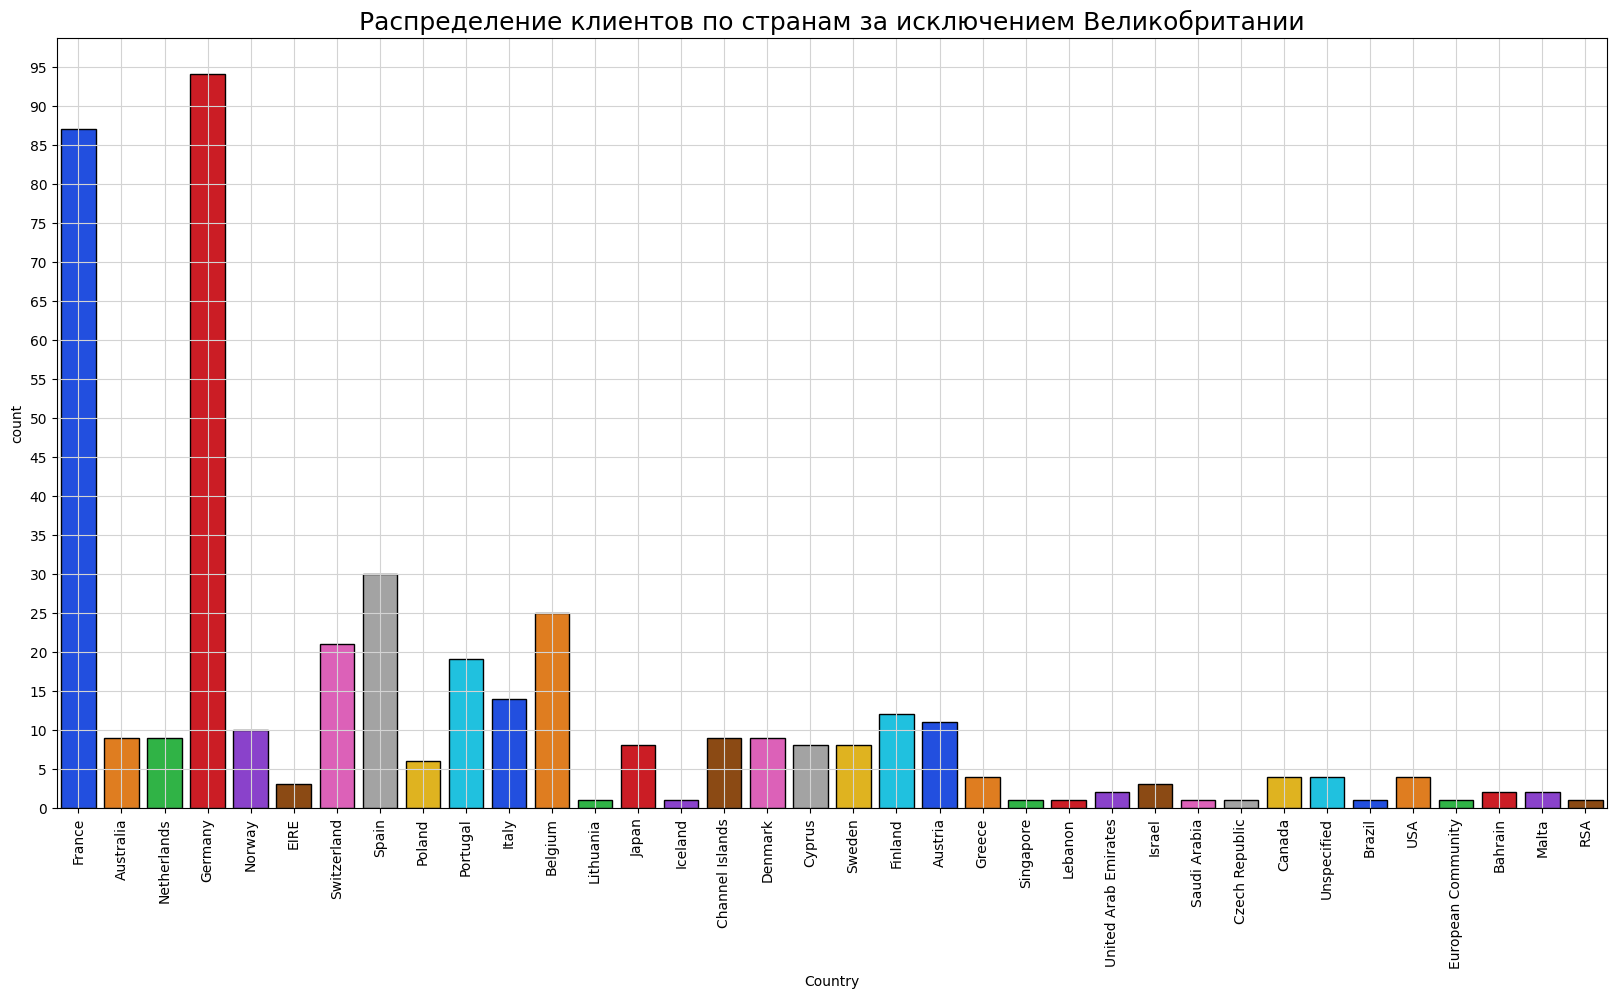

In [256]:
# исключим из таблицы Великобританию
сustomer_country_noUK = сustomer_country[сustomer_country['Country'] != 'United Kingdom']
plt.figure(figsize=(20,10))
sns.countplot(сustomer_country_noUK, x='Country', palette='bright')
plt.title('Распределение клиентов по странам за исключением Великобритании', fontsize=18)
plt.xticks(rotation=90)
plt.yticks(range(0, 100, 5))
plt.grid(color='lightgrey')
plt.show()

*Только две страны(Германия и Франция) имеют количество клиентов в пределах 85-100, все остальные страны не превышают 30.*\
*Данный признак с точки зрения облика клиента неинформативен, так как абсолютное большинство клиентов из одной страны.*

### 3.2 Распределение стран по количеству заказов

In [257]:
# группируем страны по количеству транзакций и сортируем, посмотрим на топ-10
invoice_country = data_cleaned.groupby('Country', as_index=False)['InvoiceNo'].count()\
    .sort_values(by='InvoiceNo', ascending=False).iloc[:10]
fig = px.bar(data_frame=invoice_country,
             x='Country',
             y='InvoiceNo',
             color='Country',
             width=1000,
             height=500,
             title = 'Распределение стран по количеству заказанных товаров'
             )
fig.update_layout(
    margin={"r":0,"t":20,"l":0,"b":20},
    title=dict(font=dict(size=25), automargin=True, xanchor='left'),
    yaxis = dict(tickmode = 'linear', tick0 = 0, dtick = 20000)
)
fig.show()

*Более 340000 транзакций приходится на Великобританию, что ожидаемо, учитывая, что абсолютное большинство клиентов из этой страны.*

### 3.3 Суммарная стоимость оборота на странам.
Создадим новый признак суммарной стоимости TotalPrice: 
 *общая цена(TotalPrice) = цена за единицу товара(UnitPrice) * (количество товаров в заказе(Quantity) - количество возвращённых товаров(QuantityCanceled)).*


In [258]:
data_cleaned['TotalPrice'] = data_cleaned['UnitPrice'] * (data_cleaned['Quantity'] - data_cleaned['QuantityCanceled'])
# сгруппируем страны по суммарной стоимости, отсортируем и отобразим на столбчатой диаграмме топ-10
income_country = data_cleaned.groupby('Country', as_index=False)['TotalPrice'].sum()\
    .sort_values(by='TotalPrice', ascending=False).iloc[:10]
fig = px.bar(data_frame=income_country,
             x='Country',
             y='TotalPrice',
             color='Country',
             width=1000,
             height=500,
             title = 'Распределение стран по доходности для магазина'
             )
fig.update_layout(
    margin={"r":0,"t":20,"l":0,"b":20},
    title=dict(font=dict(size=25), automargin=True, xanchor='left'),
    yaxis = dict(tickmode = 'linear', tick0 = 0, dtick = 250000)
)
fig.show()

*Германия и Франция, которые были на 2 и 3 местах по количеству клиентов и заказам, уступили по стоимости заказов Нидерландам и  Ирландии. Это может указывать на отповый характер заказов из этих стран.*

### 3.4 Создание новых признаков: месяц, день недели и час совершения покупки. Закономерности в данных признаках.

In [259]:
# создаем признак месяца покупки
data_cleaned['InvoiceMonth'] = data_cleaned['InvoiceDate'].dt.month
# создаем признак дня недели заказа
data_cleaned['InvoiceWeek'] = data_cleaned['InvoiceDate'].dt.day_name()
# создаем признак часа совершения покупки
data_cleaned['InvoiceHour'] = data_cleaned['InvoiceDate'].dt.hour

Визуализируем распределение суммарной стоимости заказов по месяцам

In [260]:
# сгруппируем месяца по сумме общей стоимости товаров, отсортируем по суммарной стоимости
income_month = data_cleaned.groupby('InvoiceMonth', as_index=False)['TotalPrice'].sum()\
    .sort_values(by='TotalPrice', ascending=False)
fig = px.bar(data_frame=income_month,
             x='InvoiceMonth',
             y='TotalPrice',
             color='InvoiceMonth',
             width=1000,
             height=500,
             title = 'Распределение суммарной стоимости заказов по месяцам'
             )
fig.update_layout(
    margin={"r":0,"t":20,"l":0,"b":20},
    title=dict(font=dict(size=25), automargin=True, xanchor='left'),
    yaxis = dict(tickmode = 'linear', tick0 = 0, dtick = 100000),
    xaxis = dict(tickmode='array', tickvals = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], 
                 ticktext=['January', 'February', 'March', 'April', 'May', 'June', 'Jule', 'August', 'September',
                           'October', 'November', 'December'])
)
fig.show()

*Наиболее прибыльные месяца сентябрь-ноябрь, возможно, люди в предверии новогодних и рождественских праздников заранее покупают подарки.*

Посмотрим на наиболее популярные дни недели по количеству заказов.


In [261]:
# сгруппируем дни недели по количеству заказов (количеству инвойс-счетов), отсортируем по количеству
invoice_week = data_cleaned.groupby('InvoiceWeek', as_index=False)['InvoiceNo'].count().sort_values(by='InvoiceNo')
fig = px.bar(data_frame=invoice_week,
             x='InvoiceWeek',
             y='InvoiceNo',
             color='InvoiceWeek',
             width=1000,
             height=500,
             title = 'Распределение покупок по дням недели'
             )
fig.update_layout(
    margin={"r":0,"t":20,"l":0,"b":20},
    title=dict(font=dict(size=25), automargin=True, xanchor='left'),
    yaxis = dict(tickmode = 'linear', tick0 = 0, dtick = 10000)
)
fig.show()

*Мы не наблюдаем субботы, возможно, что в данный день онлайн-магазин не принимает заказов(выходной), или не проводится оплаты за покупки.*

Визуализируем распределение среднего количества ежедневно поступающих заказов по времени суток (часу совершения транзакции).    

In [262]:
# выделим только дату без времени из даты совершения транзакции
data_cleaned['Date'] = data_cleaned['InvoiceDate'].dt.date
# сгруппируем количество заказов по дате и часу
quantity_date_hour = data_cleaned.groupby(['Date', 'InvoiceHour'], as_index=False)['InvoiceNo'].count()
# аггрегируем часы покупок по среднему количеству заказов 
qdh_mean = quantity_date_hour.groupby('InvoiceHour', as_index=False).mean().round().sort_values(by='InvoiceHour')

# визуализируем на круговой диаграмме среднее количество покупок в определенный час дня
fig = px.pie(qdh_mean, values='InvoiceNo', names='InvoiceHour', title='Распределение количества заказов по часам совершения покупок')
fig.update_layout(legend=dict(title='Hours', orientation='h'), margin={"r":0,"t":20,"l":0,"b":20},
    title=dict(font=dict(size=20), automargin=True, xanchor='left'))
fig.update_traces(textposition='inside', textinfo='percent+label+value')
fig.show()

*Итак, мы увидели рабочии часы приема заказов в онлайн-магазине: с 6 утра до 8 вечера. Наиболее популярное время для заказов с 10:00 до 15:00, с пиком в 12 дня - в среднем 232 заказа в этот час.*

### 3.5 Распределение клиентов по типам в зависимости от количества товаров в заказе и суммарной стоимости.

Процентное соотношение по типам клиентов в зависимости от количества товаров в заказе:
small purchase 2-10 pcs       43.57
mean purchase 11-20 pcs       21.89
single purchase 1 pcs         17.75
up mean purchase 21-50 pcs    13.24
big purchase >50 pcs           3.55
Name: customer_types, dtype: float64


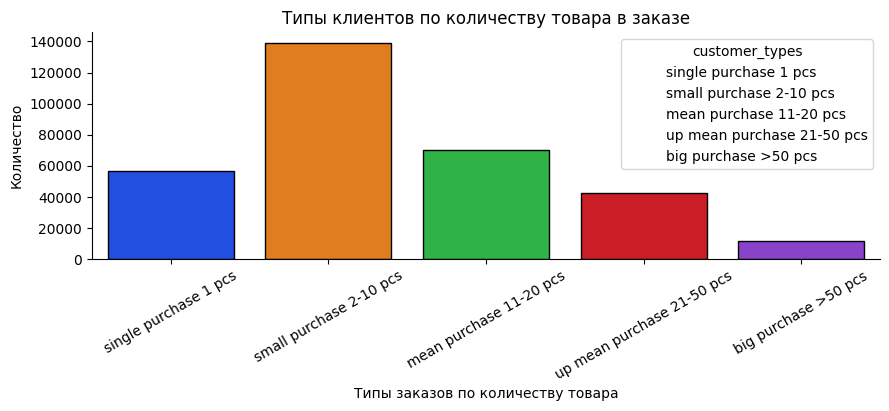

In [263]:
# создаем список видов покупок в зависимости от количества товаров
purchase_types = ['single purchase 1 pcs', 'small purchase 2-10 pcs', 'mean purchase 11-20 pcs', 
                  'up mean purchase 21-50 pcs', 'big purchase >50 pcs']
# определяем границы количества товаров в покупке
cut_groups = [1, 2, 11, 21, 51, 5000]
# создаем новый признак(тип клиента в зависимости от количества покупаемых товаров)
data_cleaned['quantity_real'] = data_cleaned['Quantity'] - data_cleaned['QuantityCanceled']
data_cleaned['customer_types'] = pd.cut(data_cleaned['quantity_real'], bins=cut_groups, labels=purchase_types)
print('Процентное соотношение по типам клиентов в зависимости от количества товаров в заказе:', 
      np.round(data_cleaned['customer_types'].value_counts(normalize=True)*100, 2), sep='\n')
# визуализируем распределение нового признака
sns.catplot(data_cleaned, x='customer_types', kind='count', palette='bright', height=3, aspect=3, legend_out=False)
plt.title('Типы клиентов по количеству товара в заказе')
plt.xlabel('Типы заказов по количеству товара')
plt.ylabel('Количество')
plt.xticks(rotation=30)
plt.show()

In [264]:
# сгруппируем типы клиентов по суммарной стоимости
price_purchase = data_cleaned.groupby(['customer_types'], as_index=False)['TotalPrice'].sum().sort_values(by='TotalPrice')
fig = px.bar(data_frame=price_purchase,
             x='customer_types',
             y='TotalPrice',
             color='customer_types',
             width=1000,
             height=500,
             title = 'Распределение суммарной стоимости в зависимости от типов клиентов',
             text_auto=True
             )
fig.update_layout(
    margin={"r":0,"t":20,"l":0,"b":20},
    title=dict(font=dict(size=25), automargin=True, xanchor='left'),
    yaxis = dict(tickmode = 'linear', tick0 = 0, dtick = 200000)
)
fig.show()

*Самыми важными клиентами магазина однозначно можно назвать оптовые компании (покупки в количестве товаров от 50 и выше), которые состаляют 3,5% от всех клиентов, но приносят суммарную стоимость заказов в размере 2,32 млн, а вот самая большая категория клиентов по численности 43,57% с небольшими заказами имеет суммарный оборот в 2,132 млн.*\
*Также средний сегмент по количеству товара от 11 до 50 шт. в заказе (35% от всех клиентов) приносит в совокупности самую большую прибыль (суммарная стоимость товаров 3 млн.), распределенная примерно пополам для клиентов с количеством товаров в покупке 21-50 шт. (13,24%) и клиентов с количеством товаров в покупке 11-20 шт. (21,9% от всех клиентов).*

## 4. RFM-сегментация клиентов: часть 1

Мы добрались до этапа сегментации. Нам предстоит сформировать признаки, на основе которых мы будем производить сегментацию клиентов.

Для этого мы воспользуемся популярным методом для анализа потребительской ценности под названием RFMQ.\
Метод заключается в группировке клиентов на основе следующих параметров:
* Recency (Давность) — давность последней покупки клиента;
* Frequency (Частота) — общее количество покупок клиента;
* Monetary Value (Денежная ценность) — сколько денег потратил клиент;
* Quantity (Количество) - срреднее количество товаров в одном заказе.

Суть RFMQ-анализа состоит в том, что мы разделяем всех клиентов на группы в зависимости от того, как давно они сделали последнюю покупку, как часто покупали, насколько большой была сумма их заказов и сколько товаров в среднем они покупали за раз.

Пример интерпретация кластеров для случая RF-сегментации (анализа на основе давности и частоты заказов клиента):
<center><img src=https://retailrocket.ru/wp-content/uploads/2017/06/rfm-1.png height=60% width=60%></center>

Задача маркетологов — вести клиента в зону лояльных.

### 4.1 Создание RFMQ-таблицы
Чтобы получить RFMQ-таблицу, нам необходимо сгруппировать данные по идентификаторам клиента и рассчитать следующие агрегированные характеристики:
* Recency для i-го клиента рассчитывается как разница между датой и временем последнего заказа и точкой отсчёта, переведённая в дни:
    $$t_0-max(t_{i1}, t_{i2},..., t_{iM})$$
    где $t_{ij}$ — дата и время совершения i-ым клиентом своей j-ой покупки.
    В качестве точки отсчёта $t_0$ берём дату на один день «старше», чем все наши данные. Это будет 10 декабря 2011 года (в формате datetime — '2011-12-10 00:00:00').
* Frequency рассчитывается как общее количество уникальных заказов, которые совершил i-ый клиент.
* Monetary Value рассчитывается как общая сумма денег, которую i-ый клиент потратил на наши товары (с учетом возвратов).
* Quantity рассчитывается как среднее количество товаров в одной покупке.

In [265]:
data_cleaned['recency'] = pd.to_datetime('2011-12-10 00:00:00') - data_cleaned['InvoiceDate']
data_cleaned['recency_day'] = data_cleaned['recency'].dt.days
recency = data_cleaned.groupby('CustomerID')['recency_day'].min()
frequency = data_cleaned.groupby('CustomerID')['InvoiceNo'].nunique()
monetary = data_cleaned.groupby('CustomerID')['TotalPrice'].sum()
quantity = data_cleaned.groupby('CustomerID')['quantity_real'].mean().round()
RFMQ_df = pd.concat([recency, frequency, monetary, quantity], axis=1)
RFMQ_df = RFMQ_df.rename(columns = {'recency_day': 'Recency', 'InvoiceNo': 'Frequency', 
                                    'TotalPrice': 'Monetary', 'quantity_real': 'Quantity'})
RFMQ_df

,Recency,Frequency,Monetary,Quantity
CustomerID,,,,
12346,325,1,0.00,0.0
12347,2,7,4310.00,14.0
12348,75,4,1437.24,86.0
12349,18,1,1457.55,9.0
12350,310,1,294.40,12.0
...,...,...,...,...
18280,277,1,180.60,4.0
18281,180,1,80.82,8.0
18282,7,2,176.60,8.0


In [266]:
# посмотрим, сколько клиентов совершили покупку более 200 дней назад
RFMQ_df[RFMQ_df['Recency']> 200].shape[0]

743

Коробчатые диаграммы для каждого из признаков:

In [267]:
boxes = [px.box(RFMQ_df, y=column) for column in RFMQ_df.columns]
fig = make_subplots(
    rows=1, cols=4, 
    subplot_titles=('Recency', 'Frequency', 'Monetary', 'Quantity')
)
for i, box in enumerate(boxes):
    fig.add_trace(boxes[i]['data'][0], row=1, col=i+1)
    fig.update_layout(yaxis = dict(tickmode = 'linear', tick0 = 0, dtick = 25))

fig.update_layout(showlegend=True, margin={"r":0,"t":20,"l":0,"b":20})
fig.show()

Мы наблюдаем выбросы: клиенты с большим количеством сделанных заказов (более 100 штук), клиенты, общая стоимость заказов которых превышает 190 тысяч фунтов стерлингов, а также клиенты со среднем количеством товаров в заказе более 1000 единиц, даже для оптовых компаний это нереально.

Выбросы могут отрицательно сказаться на результатах работы методов кластеризации, неустойчивых к ним, например алгоритма KMeans, поэтому мы избавиться от них. Мы ограничимся верхней границей, соответствующей квантилю уровня 0.95. Таким образом, мы удалим данные тех клиентов, для которых значение параметров Frequency, Monetary или Quantity выше, чем у 95 % клиентов.

### 4.2 Очистка RFMQ-таблицы от выбросов
Удаляем из RFMQ-таблицы записи о клиентах, для которых выполняется хотя бы одно из условий:
$$frequency >frequency_{0.95}$$
$$monetary >monetary_{0.95}$$ 
$$quantity >quantity_{0.99}$$ 
где $frequency_{0.95}$, $monetary_{0.95}$, $quantity_{0.99}$ - квантили уровня для соответствующих признаков. 

In [268]:
outliers = RFMQ_df[(RFMQ_df['Frequency'] > RFMQ_df['Frequency'].quantile(0.95))
            |(RFMQ_df['Monetary'] > RFMQ_df['Monetary'].quantile(0.95))
            |(RFMQ_df['Quantity'] > RFMQ_df['Quantity'].quantile(0.99))]
# сохраним копию RFMQ-таблицы
RFMQ_copy = RFMQ_df
# удаляем выбросы
RFMQ_df = RFMQ_df.drop(outliers.index)
RFMQ_df.shape

(4013, 4)

Посмотрим на коробчатые диаграммы после удаления выбросов:


In [269]:
boxes = [px.box(RFMQ_df, y=column) for column in RFMQ_df.columns]
fig = make_subplots(
    rows=1, cols=4, 
    subplot_titles=('Recency', 'Frequency', 'Monetary', 'Quantity')
)
for i, box in enumerate(boxes):
    fig.add_trace(boxes[i]['data'][0], row=1, col=i+1)
    fig.update_layout(yaxis = dict(tickmode = 'linear', tick0 = 0, dtick = 25))

fig.update_layout(showlegend=True, margin={"r":0,"t":20,"l":0,"b":20})
fig.show()

Перед этапом кластеризации нам необходимо оценить, как распределены наблюдения в пространстве признаков. 
Для визуализации мы возьмем только три параметра нашей таблицы для представления их в виде трёхмерной диаграммы рассеяния. 

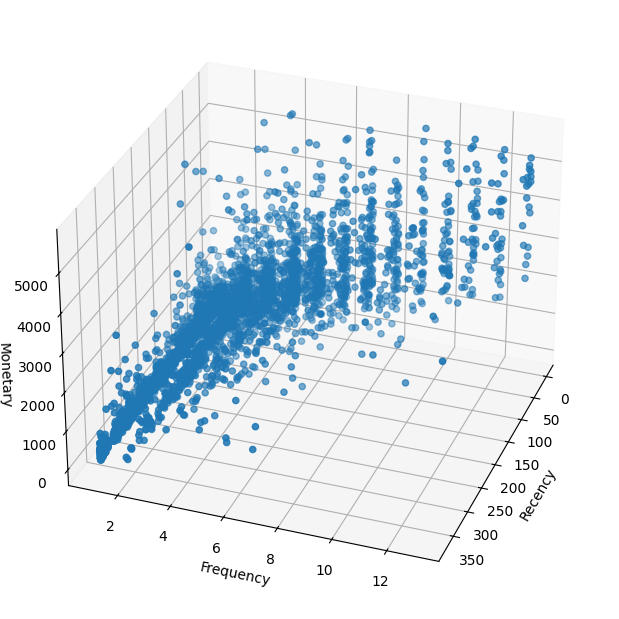

In [270]:
# создадим трёхмерный объект
fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig)
# добавим дополнительную ось в объект картинки
fig.add_axes(ax)
ax.azim = 20
ax.elev = 30
# визуализируем данные, передав значения x, y, z
ax.scatter(
    RFMQ_df['Recency'].to_list(), 
    RFMQ_df['Frequency'].to_list(),
    RFMQ_df['Monetary'].to_list()
)
# добавим оси
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary');

***Диаграмма похожа на общую массу точек без признаков какого-либо разделения, по которой сложно предположить, какое количество кластеров у нас возможно выделить.***\
***Для улучшения качества кластеризации мы воспользуемся методами снижения размерности.***

### 4.3 Снижение размерности методом главных компонент PCA
Для правильной работы метода PCA нам необходимо стандартизировать/нормализовать данные. 
Для удобства мы осуществим эти два шага в режиме автоматизации по методу pipeline:
* стандартизация с помощью StandardScaler с параметрами по умолчанию; 
* метод главных компонент с тремя компонентами.

In [271]:
pipeline = Pipeline([('scaler', preprocessing.StandardScaler()), 
                              ('pca', decomposition.PCA(n_components=3))])
RFMQ_pca = pipeline.fit_transform(RFMQ_df)
# посмотрим на дисперсию главной компоненты
pipeline['pca'].explained_variance_ratio_

array([0.51009878, 0.25458786, 0.17660424])

Визуализируем пространство двух компонент (главной и последней) после снижения размерности:

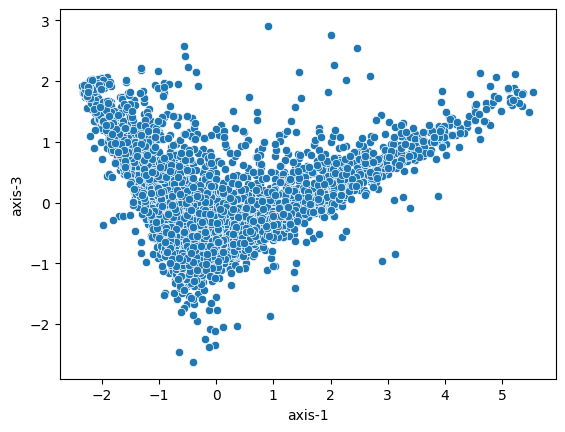

In [272]:
rfmq_pca= pd.DataFrame(RFMQ_pca, columns=['axis-1', 'axis-2', 'axis-3'], index=RFMQ_df.index)
sns.scatterplot(data=rfmq_pca, x='axis-1', y='axis-3');

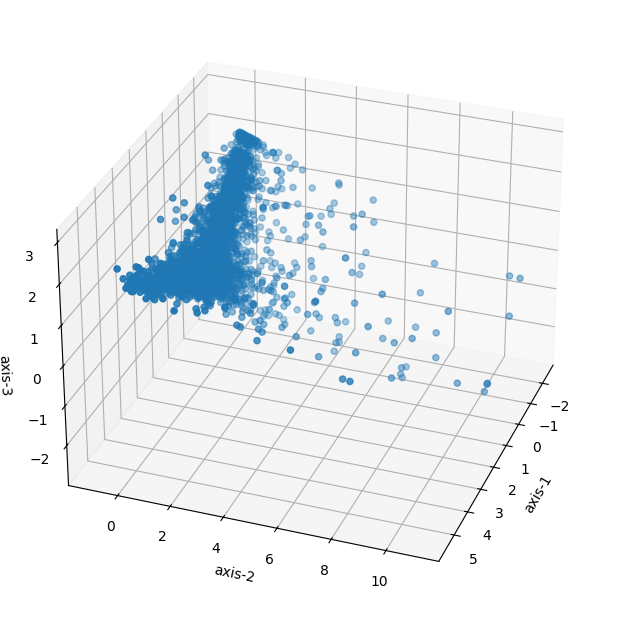

In [273]:
# создадим трёхмерный объект
fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig)
# добавим дополнительную ось в объект картинки
fig.add_axes(ax)
ax.azim = 20
ax.elev = 30
# визуализируем данные, передав значения x, y, z
ax.scatter(rfmq_pca['axis-1'].to_list(), rfmq_pca['axis-2'].to_list(), rfmq_pca['axis-3'].to_list())
# добавим оси
ax.set_xlabel('axis-1')
ax.set_ylabel('axis-2')
ax.set_zlabel('axis-3');

Больше ясности c тремя компонентами PCA не получается, а вот главная и последняя компоненты дают более определенную структуру, попробуем сократить нашу изначальную таблицу RFMQ до трех первых признаков, исключая среднее количество товаров за один заказ.\
Проделаем те же шаги по снижению размерности уже до двух компонент.

(4044, 3)
Дисперсия главной компоненты:  0.6774705317186062


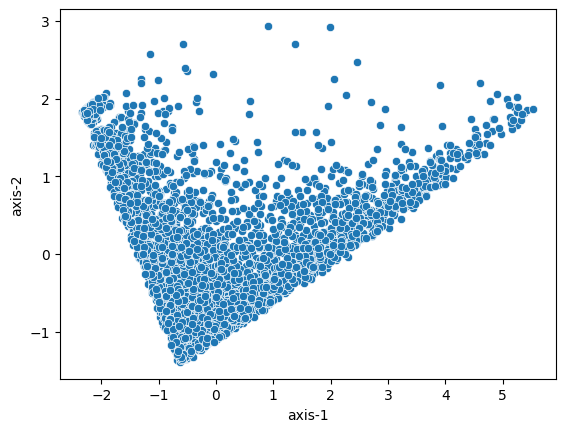

In [274]:
RFM_df = RFMQ_copy.drop('Quantity', axis=1)
outliers = RFM_df[(RFM_df['Frequency'] > RFM_df['Frequency'].quantile(0.95))
            |(RFM_df['Monetary'] > RFM_df['Monetary'].quantile(0.95))]
RFM_df = RFM_df.drop(outliers.index)
print(RFM_df.shape)
pipeline_rfm = Pipeline([('scaler', preprocessing.StandardScaler()), 
                              ('pca', decomposition.PCA(n_components=2))])
RFM_pca = pipeline_rfm.fit_transform(RFM_df)
# посмотрим на дисперсию главной компоненты
print('Дисперсия главной компоненты: ', pipeline_rfm['pca'].explained_variance_ratio_[0])
# создаем датафрейм из преобразованной таблицы RFM_df до двух компонент и визуализируем
rfm_pca= pd.DataFrame(RFM_pca, columns=['axis-1', 'axis-2'], index=RFM_df.index)
sns.scatterplot(data=rfm_pca, x='axis-1', y='axis-2');

Удаление признака Quantity из таблицы RFMQ изменило значение дисперсии главной компоненты (то есть сокращение размерности прошло более успешно), а график стал более определенным.\
Но по форме пространства, мы можем с уверенностью сказать, что нам не подойдут алгоритмы, основанные на плотности, такие как DBSCAN, так как точки расположены очень близко друг к другу и большая часть точек будет определена в единый кластер, что не имеет смысла.

Попробуем разделить пространство главных компонент на сегменты. 

### 4.4 Кластеризация методом k-means
Чтобы определить наиболее оптимальное количество кластеров, переберем значения [2, 10] с помощью коэффициента силуэта.

1. Подбираем оптимальное число кластеров для таблицы rfmq_pca (трехкомпонентное сокращение размерности таблицы RFMQ_df)

Максимальное значение коэффициента:  0.45995354258404075


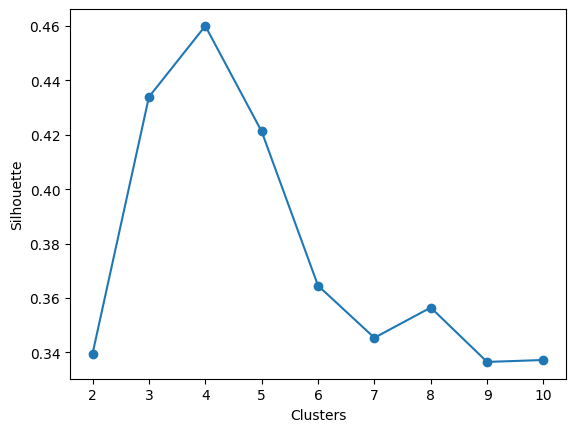

In [275]:
scores_rfmq = []
for num_cluster in range(2,11):
    kmean = cluster.KMeans(random_state=42, n_clusters=num_cluster)
    kmean.fit_predict(rfmq_pca)
    scores_rfmq.append(metrics.silhouette_score(rfmq_pca, kmean.labels_))
print('Максимальное значение коэффициента: ', max(scores_rfmq))  
plt.xlabel('Clusters')
plt.ylabel('Silhouette')
plt.plot([i for i in range(2, 11)], scores_rfmq, 'o-');

2. Подбираем оптимальное число кластеров для таблицы rfm_pca (двухкомпонентное сокращение размерности таблицы RFM_df)

Максимальное значение коэффициента:  0.5241446311342408


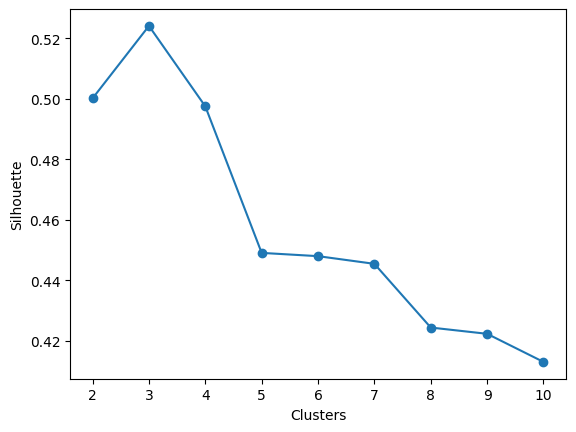

In [276]:
scores_rfm = []
for num_cluster in range(2,11):
    kmean = cluster.KMeans(random_state=42, n_clusters=num_cluster)
    kmean.fit_predict(rfm_pca)
    scores_rfm.append(metrics.silhouette_score(rfm_pca, kmean.labels_))
print('Максимальное значение коэффициента: ', max(scores_rfm))  
plt.xlabel('Clusters')
plt.ylabel('Silhouette')
plt.plot([i for i in range(2, 11)], scores_rfm, 'o-');

***Мы видим разное количество кластеров: 4 предлагает кластеризация трехкомпонентной таблицы по метода RFMQ и 3 кластера  - для двухкомпонентной таблицы по метода RFM, во второй кластеризации значение коэффициента выше, значит, кластерная структура более четкая по сравнению с первой.***

### 4.5 Кластеризация с помощью EM-алгоритма.
Применим алгоритм GaussianMixture и также с помощью коэффициента силуэта определим оптимальное количество кластеров.

1. Подбираем оптимальное число кластеров для таблицы rfmq_pca (трехкомпонентное сокращение размерности таблицы RFMQ_df)

Максимальное значение коэффициента:  0.37076738501203377


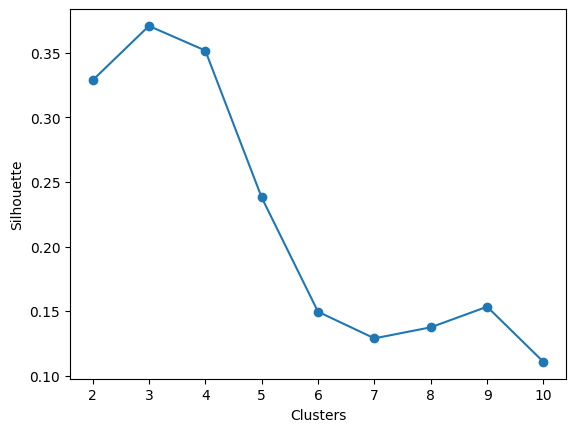

In [277]:
scores_gmm_rfmq = []
for num_cluster in range(2,11):
    gmm = mixture.GaussianMixture(random_state=42, n_components=num_cluster)
    predictions = gmm.fit_predict(rfmq_pca)
    scores_gmm_rfmq.append(metrics.silhouette_score(rfmq_pca, predictions))
print('Максимальное значение коэффициента: ', max(scores_gmm_rfmq))  
plt.xlabel('Clusters')
plt.ylabel('Silhouette')
plt.plot([i for i in range(2, 11)], scores_gmm_rfmq, 'o-');

2. Подбираем оптимальное число кластеров для таблицы rfm_pca (двухкомпонентное сокращение размерности таблицы RFM_df)

Максимальное значение коэффициента:  0.4358290663917996


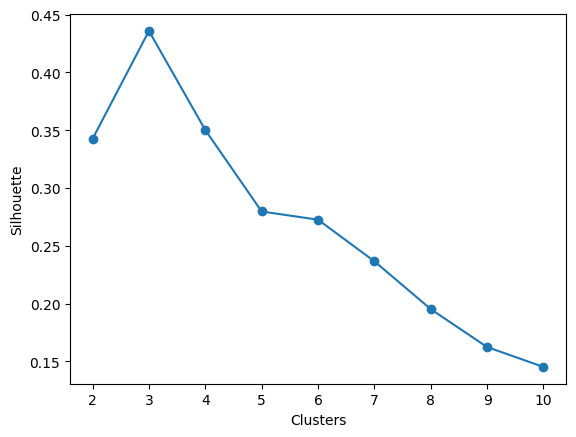

In [278]:
scores_gmm_rfm = []
for num_cluster in range(2,11):
    gmm = mixture.GaussianMixture(random_state=42, n_components=num_cluster)
    predictions = gmm.fit_predict(rfm_pca)
    scores_gmm_rfm.append(metrics.silhouette_score(rfm_pca, predictions))
print('Максимальное значение коэффициента: ', max(scores_gmm_rfm))  
plt.xlabel('Clusters')
plt.ylabel('Silhouette')
plt.plot([i for i in range(2, 11)], scores_gmm_rfm, 'o-');

***Картина у нас по кластерам немного изменилась, для обеих моделей оптимально 3 кластера, но значение коэффициентов упало, одназначно данный алгоритм нам не подходит.***

### 4.6 Визуализация кластеров
Наибольшее значение коэффициента силуэта 0.52 показала модель кластеризации на основе алгоритма KMeans для таблицы RFM (Давность, Частота, Денежный эквивалент), сокращенной размерности по методу PCA.

In [279]:
kmean_opt = cluster.KMeans(n_clusters=3, random_state=42)
kmean_opt.fit_predict(rfm_pca)
labels = pd.Series(kmean_opt.labels_, index=RFM_df.index)
labels.value_counts()

2    2270
1    1001
0     773
dtype: int64

Визуализируем результаты кластеризации:

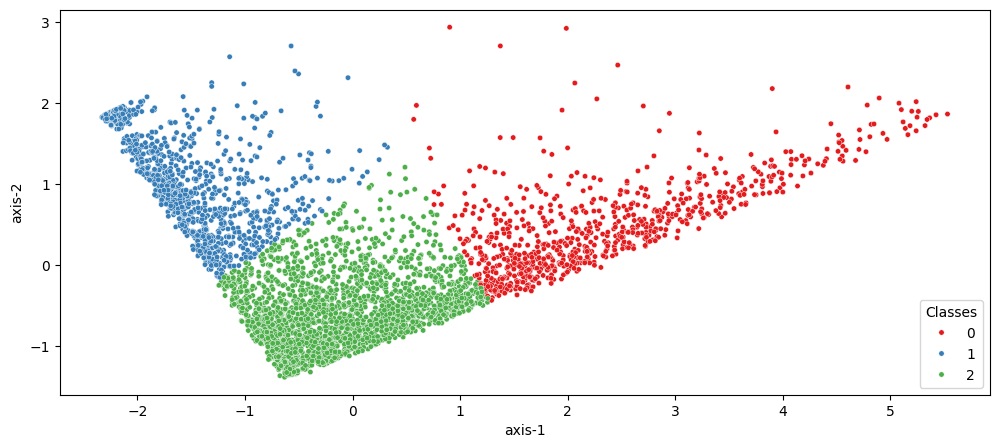

In [280]:
plt.figure(figsize=(12, 5))
sns.scatterplot(
    data=rfm_pca, 
    x='axis-1', 
    y='axis-2', 
    hue=labels,
    palette = 'Set1', s=15
)
plt.legend(title='Classes', loc='lower right');

***Итак, у нас есть три сегмента клиентов. Переходим к составлению профиля для этих сегментов.***

### 4.7 Составление профилей для сегментрованных на три кластера клиентов.

Для составления профиля кластеров нам необходимо вернуться от декомпозированных данных к RFM-таблице, очищенной от выбросов.  Сгруппируем RFM-таблицу по полученным кластерам и посмотрим на среднее по каждому из признаков.

In [281]:
RFM_df_clusters = pd.concat([RFM_df, labels], axis=1)
RFM_df_clusters = RFM_df_clusters.rename(columns = {0: 'Clusters'})
RFM_df_clusters

,Recency,Frequency,Monetary,Clusters
CustomerID,,,,
12346,325,1,0.00,1
12347,2,7,4310.00,0
12348,75,4,1437.24,2
12349,18,1,1457.55,2
12350,310,1,294.40,1
...,...,...,...,...
18278,73,1,173.90,2
18280,277,1,180.60,1
18281,180,1,80.82,1


In [282]:
# среднее значение признаков по каждому кластеру
mean_rfm_df = RFM_df_clusters.groupby('Clusters').mean()
mean_rfm_df.round()

,Recency,Frequency,Monetary
Clusters,,,
0,32.0,7.0,2662.0
1,253.0,1.0,387.0
2,51.0,2.0,661.0


* Мы видим, что самый малочисленный сегмент 0 достаточно активен (недавние покупки), среднее количество заказов от этих клиентов = 7 и самая высокая суммарная стоимость заказов. Скорее всего это оптовые компании.
* Сегмент 1 (около четверти всех клиентов) - очень давно не совершали заказов, учитывая, что они в среднем сделали один заказ, это похоже на разовую индивидуальную покупку и необходимо понять, почему они "не вернулись" в магазин и можно ли их сделать постоянными клиентами или они уже "потеряны" для магазина.
* Сегмент 2 (более половины всех клиентов) - характеризуется не частыми небольшими заказами, но периодически активны и необходимо оживить их интерес или напомнить о себе.

### 4.8 Анализ средних RFM-характеристик с помощью визуализации на полярной диаграмме
Radar Chart (полярная, или лепестковая, диаграмма) - графическое представление значений нескольких эквивалентных категорий в форме «паутины».\
Radar Chart очень часто используется в контексте определения профиля кластеров. На концах «паутины» откладываются оси, которые соответствуют признакам, описывающим объекты. На каждой из осей для каждого кластера откладываются средние значения соответствующих характеристик. Соединив точки по осям, мы получаем многоугольник.

В модуле graph_objects библиотеки plotly есть встроенная функция Scatterpolar, которая позволяет построить полярную диаграмму. На основе этой функции мы реализовали собственную функцию plot_cluster_profile(), которая позволяет визуализировать профиль каждого из кластеров в виде полярной диаграммы. У этой функции два параметра: grouped_data — сгруппированные по кластерам характеристики объектов (клиентов), n_clusters — количество кластеров. 

Главное условие использования полярной диаграммы — все признаки должны быть приведены к единому масштабу с помощью нормализации, где 1 будет означать максимум, а 0 — минимум.

In [283]:
def plot_cluster_profile(grouped_data, n_clusters):
    # Нормализуем сгруппированные данные, приводя их к масштабу 0-1.
    scaler = preprocessing.MinMaxScaler()
    grouped_data = pd.DataFrame(scaler.fit_transform(grouped_data), columns=grouped_data.columns)
    # Создаем список признаков
    features = grouped_data.columns
    # Создаем пустую фигуру
    fig = go.Figure()
    # В цикле визуализируем полярную диаграмму для каждого кластера
    for i in range(n_clusters):
        # Создаем полярную диаграмму и добавляем ее на общий график
        fig.add_trace(go.Scatterpolar(
            r=grouped_data.iloc[i].values, # радиусы
            theta=features, # название засечек
            fill='toself', # заливка многоугольника цветом
            name=f'Cluster {i}', # название - номер кластера
        ))
    # Обновляем параметры фигуры
    fig.update_layout(
        showlegend=True, # отображение легенды
        autosize=False, # устаналиваем свои размеры графика
        width=650, # ширина (в пикселях)
        height=650, # высота (в пикселях)
        margin={"r":0,"t":20,"l":0,"b":20}
    )
    # Отображаем фигуру
    fig.show()

In [284]:
# применим функцию
plot_cluster_profile(mean_rfm_df, 3)

**Результаты сегментации:**
* Кластер 0 соответствует «лояльным» клиентам, которые приносят наибольший доход, совершают покупки чаще всего, а давность их последней покупки наименьшая.
* Кластер 2 соответствует «промежуточным» клиентам, которые являются активными, но покупают не так часто и много, как лояльные клиенты. В то же время эти клиенты не являются «потерянными».
* Кластер 1 соответствует «потерянным» клиентам, которые купили меньше всего товара, и их последняя покупка была совершена очень давно.

## 5. RFM-сегментация клиентов: часть 2

Итак, кластеризация данных, сокращенных с помощью PCA, определила три сегмента клиентов RFM-анализа. Однако в маркетинге принято оперировать большим их количеством: обычно маркетологи стараются создать стратегию хотя бы для пяти-семи клиентских сегментов в градации от «лояльных» до «потерянных» с промежуточными категориями.

Теперь мы применим к нашим данным не линейный метод понимения размерности PCA, а нелинейную трансформацию алгоритма t-SNE.

### 5.1 Понижение размерности с помощью t-SNE
Реализуем ту же схему, как прежде, создаем pipeline, который будет содержать следующие шаги:
* стандартизация с помощью StandardScaler с параметрами по умолчанию; 
* алгоритм t-SNE с двумя компонентами, параметрами perplexity=50 и random_state=100.

Оценку качества трансформации с t-распределением определим с помощью дивергенции Кульбака-Лейблера - это функция потерь, которая минимизируется при обучения алгоритма t-SNE. Она показывает меру расстояния между двумя распределениями. 

In [285]:
# трансформируем таблицу RFMQ_df
pipeline = Pipeline([('scaler', preprocessing.StandardScaler()), 
                              ('tsne', manifold.TSNE(n_components=2, perplexity=50, random_state=100))])
RFMQ_tsne = pipeline.fit_transform(RFMQ_df)
# значение дивергенции Кульбака-Лейблера
pipeline['tsne'].kl_divergence_

0.8252654075622559

In [286]:
# трансформируем таблицу RFM_df
pipeline_rfm = Pipeline([('scaler', preprocessing.StandardScaler()), 
                              ('tsne', manifold.TSNE(n_components=2, perplexity=50, random_state=100))])
RFM_tsne = pipeline_rfm.fit_transform(RFM_df)
# значение дивергенции Кульбака-Лейблера
pipeline_rfm['tsne'].kl_divergence_

0.5415332317352295

Визуализируем оба набора данных после декомпозиции с помощью t-SNE.

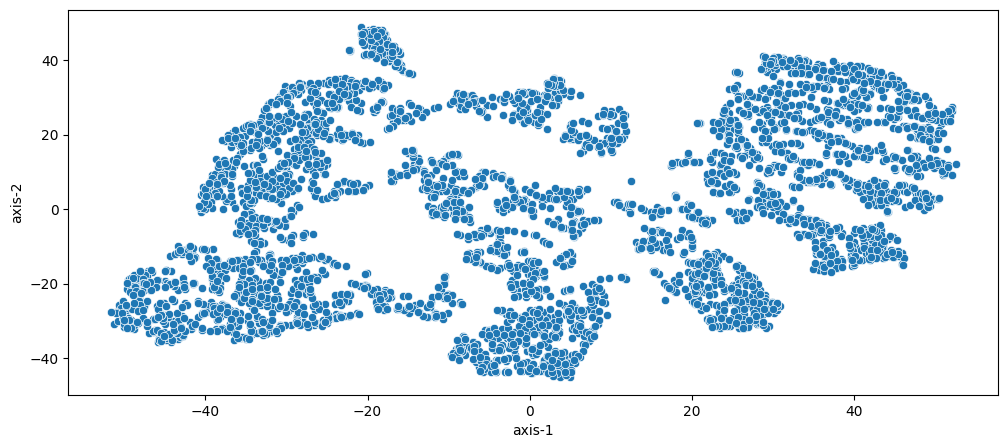

In [287]:
rfmq_tsne= pd.DataFrame(RFMQ_tsne, columns=['axis-1', 'axis-2'], index=RFMQ_df.index)
plt.figure(figsize=(12, 5))
sns.scatterplot(data=rfmq_tsne, x='axis-1', y='axis-2');

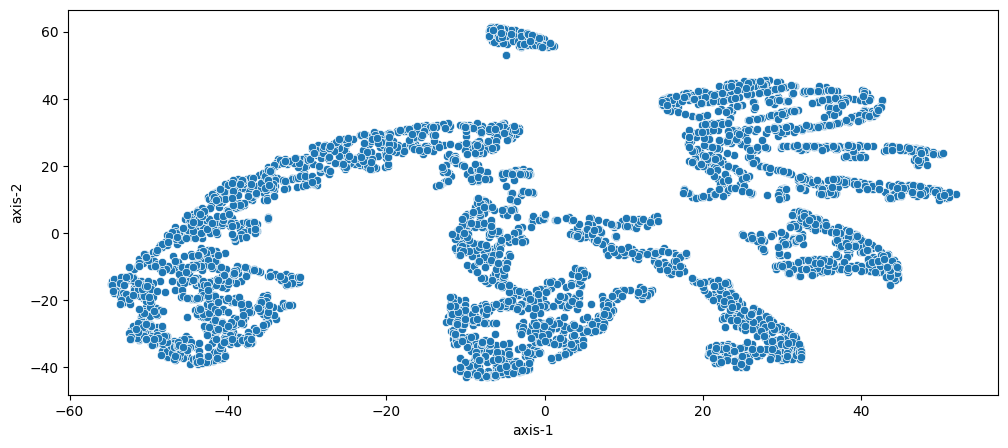

In [288]:
rfm_tsne= pd.DataFrame(RFM_tsne, columns=['axis-1', 'axis-2'], index=RFM_df.index)
plt.figure(figsize=(12, 5))
sns.scatterplot(data=rfm_tsne, x='axis-1', y='axis-2');

***Трансформация t-SNE для RFMQ-таблицы оказалась не слишком удачной, кластеры сложно определяемы, досточно разрознены и значение дивергенции высокое.***\
***А вот данные RFM-таблицы после снижения размерности с помощью t-SNE однозначно сгруппировались в кластеры.***

Далее мы будем подбирать оптимальный алгоритм для кластеризации только для RFM-таблицы.

### 5.2 Кластеризация с помощью метода k-means

Максимальное значение коэффициента:  0.482


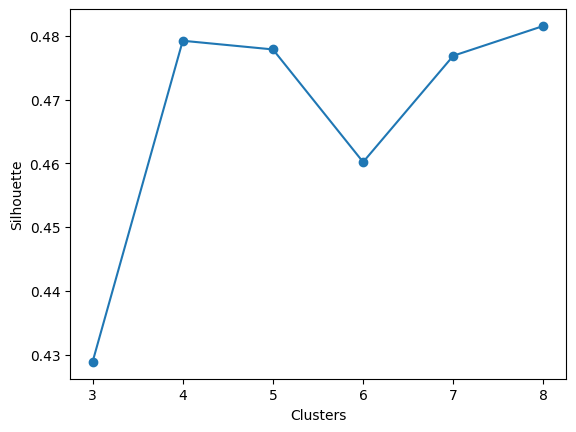

In [289]:
scores_tsne_rfm = []
for num_cluster in range(3, 9):
    kmean = cluster.KMeans(random_state=42, n_clusters=num_cluster)
    kmean.fit_predict(rfm_tsne)
    scores_tsne_rfm.append(metrics.silhouette_score(rfm_tsne, kmean.labels_))
print('Максимальное значение коэффициента: ', max(scores_tsne_rfm).round(3))
plt.xlabel('Clusters')
plt.ylabel('Silhouette')
plt.plot([i for i in range(3, 9)], scores_tsne_rfm, 'o-');

### 5.3 Кластеризация с помощью EM-алгоритма (GaussianMixture)

Максимальное значение коэффициента:  0.469


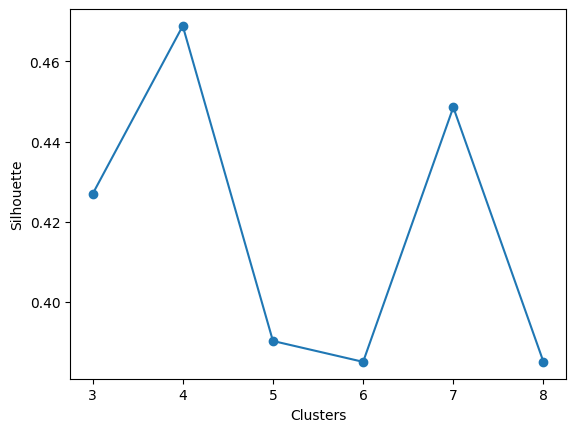

In [290]:
scores_gmm_tsne = []
for num_cluster in range(3, 9):
    gmm = mixture.GaussianMixture(random_state=42, n_components=num_cluster)
    predictions = gmm.fit_predict(rfm_tsne)
    scores_gmm_tsne.append(metrics.silhouette_score(rfm_tsne, predictions))
print('Максимальное значение коэффициента: ', max(scores_gmm_tsne).round(3))
plt.xlabel('Clusters')
plt.ylabel('Silhouette')
plt.plot([i for i in range(3, 9)], scores_gmm_tsne, 'o-');

***Данный алгоритм понизил нам качество кластеризации и сократил оптимальное количество кластеров по сравнению с KMeans с 8 до 4.***

### 5.4 Алгоритм алгомеративной кластеризации (AgglomerativeClustering)

Максимальное значение коэффициента:  0.479


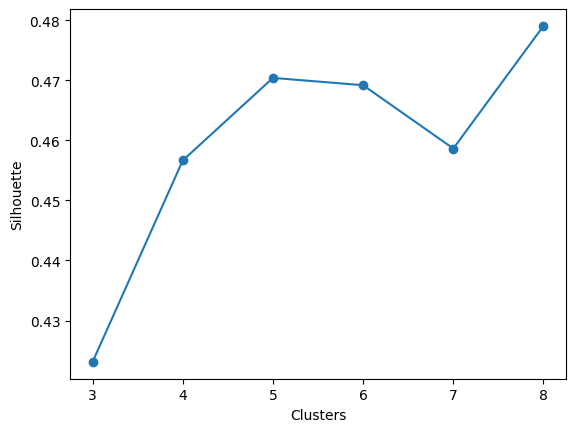

In [291]:
scores_aggl_tsne = []
for num_cluster in range(3, 9):
    aggl = cluster.AgglomerativeClustering(n_clusters=num_cluster)
    aggl.fit_predict(rfm_tsne)
    scores_aggl_tsne.append(metrics.silhouette_score(rfm_tsne, aggl.labels_))
print('Максимальное значение коэффициента: ', max(scores_aggl_tsne).round(3))
plt.xlabel('Clusters')
plt.ylabel('Silhouette')
plt.plot([i for i in range(3, 9)], scores_aggl_tsne, 'o-');

Оценим результаты значений коэффициента силуэта для всех моделей кластеризации

In [292]:
silhouette = pd.DataFrame({'KMeans': scores_tsne_rfm, 
                           'GaussianMixture': scores_gmm_tsne,
                           'AgglomerativeClustering': scores_aggl_tsne},
                           index=[3, 4, 5, 6, 7, 8])
silhouette.round(decimals=3)

,KMeans,GaussianMixture,AgglomerativeClustering
3,0.429,0.427,0.423
4,0.479,0.469,0.457
5,0.478,0.390,0.470
6,0.460,0.385,0.469
7,0.477,0.449,0.459
8,0.482,0.385,0.479


***Наиболее четкую кластеризацию дал алгоритм KMeans.***

### 5.5 Визуализация кластеров клиентов по результатам наилучшей модели.
KMeans дает очень хорошее разбиение для 4, 5, 7 и 8 кластеров, так как мы хотели создать сегментацию не только по 3 группам(потерянные, промежуточные, лояльные), но с промежуточными характеристиками, давайте выберем 5 кластеров.

In [293]:
kmean_opt = cluster.KMeans(random_state=42, n_clusters=5)
kmean_opt.fit_predict(rfm_tsne)
cluster_tsne = pd.Series(kmean_opt.labels_, index=rfm_tsne.index)
cluster_tsne.value_counts()

0    911
4    853
3    814
1    767
2    699
dtype: int64

Визуализируем результаты кластеризации:

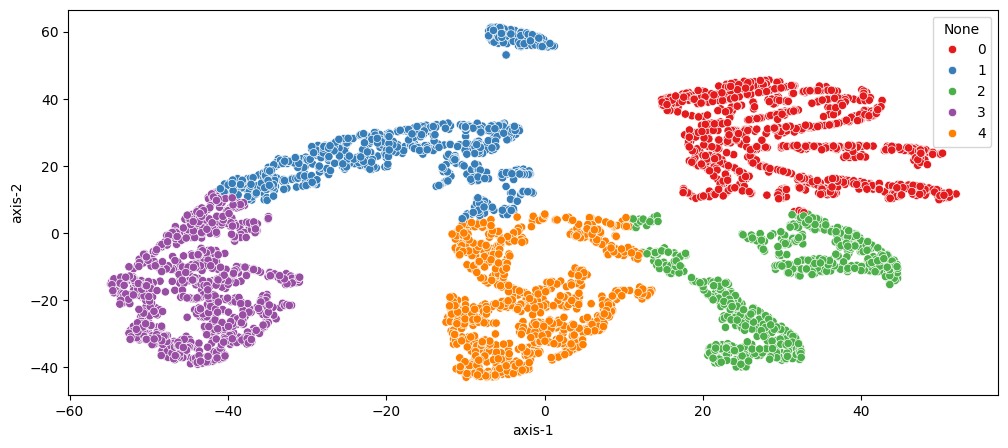

In [294]:
fig = plt.figure(figsize=(12, 5))
sns.scatterplot(data=rfm_tsne, x='axis-1', y='axis-2', hue=cluster_tsne, palette='Set1');

### 5.6 Составление профилей выделенных кластеров.
Для составления профиля кластеров нам необходимо вернуться от декомпозированных данных к RFM-таблице (очищенной от выбросов) и рассчитать среднее по каждому из признаков, сгруппированных по кластерам.

In [295]:
RFM_df_clusters = pd.concat([RFM_df, cluster_tsne], axis=1)
RFM_df_clusters = RFM_df_clusters.rename(columns = {0: 'Clusters'})
RFM_df_clusters

,Recency,Frequency,Monetary,Clusters
CustomerID,,,,
12346,325,1,0.00,1
12347,2,7,4310.00,0
12348,75,4,1437.24,2
12349,18,1,1457.55,4
12350,310,1,294.40,1
...,...,...,...,...
18278,73,1,173.90,3
18280,277,1,180.60,1
18281,180,1,80.82,1


Процентное разбиение клиентов по кластерам

In [296]:
(RFM_df_clusters['Clusters'].value_counts(normalize=True)*100).round(1)

0    22.5
4    21.1
3    20.1
1    19.0
2    17.3
Name: Clusters, dtype: float64

In [297]:
# средние значения признаков по каждому кластеру
RFM_df_clusters.groupby('Clusters').mean().round()

,Recency,Frequency,Monetary
Clusters,,,
0,32.0,7.0,2418.0
1,275.0,1.0,326.0
2,45.0,4.0,980.0
3,63.0,1.0,318.0
4,83.0,2.0,645.0


Визуализируем кластеры на полярной диаграмме

In [298]:
plot_cluster_profile(RFM_df_clusters.groupby('Clusters').mean().round(), 5)

### Описание профилей кластеров:
* Кластер 0 (лидирующий - 22.5% ) соответствует «лояльным» клиентам, которые приносят наибольший доход, совершают покупки чаще всего, а давность их последней покупки наименьшая. Это оптовые клиенты магазина.
* Кластер 2 (самый малочисленный 17.3%) соответствует «перспективным» клиентам, которые являются активными покупателями, но покупают не так часто и не так много, как лояльные клиенты.
* Кластер 4 (второй по величине - 21.1%) соответствует "подвисшим" клиентам, которые довольно давно (в среднем 3 месяца назад) сделали несколько заказов на небольшие суммы. Однозначно, необходимо напомнить данной группе о существовании магазина какой-нибудь акцией, они точно могут перейти в сегмент "перспективных".
* Кластер 3 (20.1%) соответствует клиентам «в зоне риска», которые относительно недавно более двух месяцев назад в большинстве своем совершили разовую индивидуальную покупку на небольшую сумму. Но прошло не так много времени, можно привлечь их внимание и возможно выгодные акции переведут их в сегмент "перспективных" или "лояльных" клиентов. 
* Кластер 1 (19%) соответствует «потерянным» клиентам, которые в среднем совершили разовую покупку очень давно более 9 месяцев назад. Можно о себе напомнить им или лучше сосредоточиться на других группах клиентах, особенно кластер 3, у которого впечатления о покупке в магазине еще досточно свежи.

## 6. RFM-кластеризация клиентов: часть 3

Последняя наша задача - это создать модель, которая будет для новых данных предсказывать, к какому сегменту относятся клиенты, то есть классифицировать их.

Теперь у нас есть истинные метки кластеров, а есть клиенты, которые описываются RFM-характеристиками. Обучим модель, которая на основе RFM-характеристик будет предсказывать клиентский сегмент. 

### 6.1 Разбиение набора данных на тренировочную и тестовую выборки

In [299]:
X = RFM_df
y = RFM_df_clusters['Clusters']
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=42)
print('Размер тренировочной выборки: ', X_train.shape, 'Размер тестовой выборки: ', X_test.shape, sep='\n')

Размер тренировочной выборки: 
(3235, 3)
Размер тестовой выборки: 
(809, 3)


Далее мы построим несколько моделей и выбрем из них лучшую. 
Мы знаем, что алгоритм t-SNE является нелинейным методом понижения размерности. Поэтому линейные модели, такие как логистическая регрессия, в данной задаче нам мало чем помогут. Обратимся к ансамблевым алгоритмам.

### 6.2 Алгоритм случайного леса 
Начнём со случайного леса. Для подбора наилучших гиперпараметров воспользуемся оптимизатором GridSearchCV из библиотеки sklearn.

In [300]:
# задаем сетки гиперпараметров для перебора
param_grid = {
    'max_depth': range(5, 15),             # максимальная глубина дерева
    'criterion': ['gini', 'entropy'],      # критерий информативности
    'n_estimators': [100, 200, 500]        # количество деревьев
}
# инициализируем оптимизатор и передаем ему параметры
rfc = model_selection.GridSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=42),  # классификатор случайный лес
    param_grid=param_grid,
    cv=5,                                                        # количество фолдов для кросс-валидации
    scoring='accuracy',                                          # метрика оценки качества
    n_jobs=-1
)
# обучаем модель
%time rfc.fit(X_train, y_train)
print('Accuracy на обучающем наборе: {:.3f}'.format(rfc.score(X_train, y_train)))
print('Accuracy на тестовом наборе: {:.3f}'.format(rfc.score(X_test, y_test)))
print('Наилучшие значения гиперпараметров: {}'.format(rfc.best_params_))

CPU times: total: 2.45 s
Wall time: 1min 9s
Accuracy на обучающем наборе: 1.000
Accuracy на тестовом наборе: 0.993
Наилучшие значения гиперпараметров: {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 500}


In [301]:
# сделаем предсказание алгоритмом с лучшими гиперпараметрами и выведем отчет с метриками оценки качества классификатора
forest = rfc.best_estimator_
y_pred = forest.predict(X_test)
print(metrics.classification_report(y_test, y_pred, digits=3))

              precision    recall  f1-score   support

           0      0.989     0.984     0.986       182
           1      1.000     0.993     0.997       153
           2      0.978     0.985     0.982       137
           3      1.000     1.000     1.000       170
           4      0.994     1.000     0.997       167

    accuracy                          0.993       809
   macro avg      0.992     0.992     0.992       809
weighted avg      0.993     0.993     0.993       809



Определение значимости признаков для построения алгоритма случайного леса.

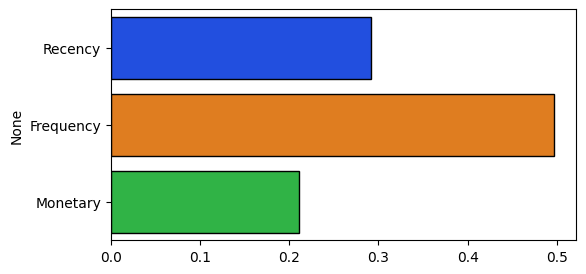

In [302]:
fig = plt.figure(figsize=(6, 3))
features = RFM_df.columns
feature_importance = forest.feature_importances_
sns.barplot(y=features, x=feature_importance, palette='bright')
plt.show()

***Итак, значения метрик очень высокие. Но мы попробуем еще улучшить, воспользовавшись бустингом.***

### 6.3 Алгоритм градиентного бустинга
Мы также определим лучшие гиперпараметры с помощью GridSearchCV.

In [303]:
param_grid = {
    'max_depth': range(3, 7),                # максимальная глубина дерева
    'learning_rate': [0.001, 0.01, 0.1],     # темп обучения
    'n_estimators': [100, 200, 500]          # количество деревьев
}
gbc = model_selection.GridSearchCV(
    estimator=ensemble.GradientBoostingClassifier(random_state=42), # классификатор градиентного бустинга
    param_grid=param_grid,
    cv=5,                                                           # количество фолдов для кросс-валидации
    scoring='accuracy',                                             # метрика оценки качества
    n_jobs=-1
)
%time gbc.fit(X_train, y_train)
print('Accuracy на обучающем наборе: {:.3f}'.format(gbc.score(X_train, y_train)))
print('Accuracy на тестовом наборе: {:.3f}'.format(gbc.score(X_test, y_test)))
print('Наилучшие значения гиперпараметров: {}'.format(gbc.best_params_))

CPU times: total: 2.62 s
Wall time: 4min 38s
Accuracy на обучающем наборе: 1.000
Accuracy на тестовом наборе: 0.989
Наилучшие значения гиперпараметров: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100}


In [304]:
# используя модель с наилучшими гиперпараметрами сделаем предсказание и выведем значения метрик для классификации
grad_boost = gbc.best_estimator_
y_pred = grad_boost.predict(X_test)
print(metrics.classification_report(y_test, y_pred, digits=3))

              precision    recall  f1-score   support

           0      0.978     0.984     0.981       182
           1      1.000     0.987     0.993       153
           2      0.971     0.993     0.982       137
           3      1.000     1.000     1.000       170
           4      0.994     0.982     0.988       167

    accuracy                          0.989       809
   macro avg      0.989     0.989     0.989       809
weighted avg      0.989     0.989     0.989       809



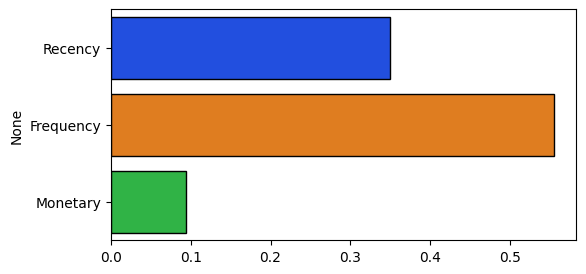

In [305]:
# посмотрим на значимость признаков для данной модели
fig = plt.figure(figsize=(6, 3))
features = RFM_df.columns
feature_importance = grad_boost.feature_importances_
sns.barplot(y=features, x=feature_importance, palette='bright')
plt.show()

### 6.4 Градиентный бустинг Catboost

In [306]:
# инициализируем алгоритм градиентного бустинга для классификации
catboost = CatBoostClassifier(      l2_leaf_reg=3,
                                    leaf_estimation_method='Newton',
                                    leaf_estimation_iterations=5, 
                                    iterations=5000,
                                    depth=6,
                                    learning_rate=0.07,
                                    loss_function='MultiClass',
                                    eval_metric='Accuracy',
                                    random_seed=42
                                    )
catboost.fit(
    X_train, y_train,
    eval_set=(X_test, y_test),
    use_best_model=True,
    early_stopping_rounds=100,
    verbose=False
)
y_pred_test = catboost.predict(X_test)
print(metrics.classification_report(y_test, y_pred_test, digits=3))
print('Accuracy на тестовой выборке: {:.3f}'.format(metrics.accuracy_score(y_test, y_pred_test)))

              precision    recall  f1-score   support

           0      0.984     0.989     0.986       182
           1      0.987     0.987     0.987       153
           2      0.986     0.993     0.989       137
           3      1.000     0.988     0.994       170
           4      0.994     0.994     0.994       167

    accuracy                          0.990       809
   macro avg      0.990     0.990     0.990       809
weighted avg      0.990     0.990     0.990       809

Accuracy на тестовой выборке: 0.990


In [307]:
catboost.get_feature_importance(prettified=True)

,Feature Id,Importances
0,Frequency,66.625957
1,Recency,20.773150
2,Monetary,12.600893


## <center>Заключение</center>
1. Мы сегментировали всех клиентов магазина на 5 кластеров, чтобы маркетологи смогли подобрать стратегии для каждого сегмента. 
2. Мы видим, что 5-я часть клиентов (один из сегментов) очень давно совершила покупку в малом количестве товара и, возможно, про этих клиентов лучше забыть и потратить ресурсы на клиентов "в зоне риска" и "подвисших", их покупки в среднем совершены 2-3 месяца назад, так как временные рамки предоставленных данных один год с декабря по декабрь и мы наблюдали, что самый высокий спрос с сентября по ноябрь, то как раз эти категории клиентов скорее всего активны осенью и покупают подарки к новогодним праздникам. Так как размер заказа небольшой, это это категория физических лиц, которые в среднем покупают 1-2 товара.
3. Важно, чтобы и маркетинговая кампания начиналась с началом осени, так как в этот период клиенты более заинтересованы в ассортименте данного магазина.
4. Возможно, магазину необходимо расширить ассортимент, чтобы он был актуален для различных праздников в течение всего года.
5. Большая часть прибыли зависит от крупных оптовых компаний (более 50 товаров в одном заказе) и оптовых (20-50 товаров в инвойсе) и они являются самыми лояльными клиентами, но возможно расширенние ассортимента также увеличит и интерес этих клиентов и соотвественно рост прибыли.
6. Наиболее значимым для определения профиля клиента является частота совершения заказов (Frequency).
7. Алгоритм случайного леса показал очень высокое качество прогнозирования кластеров (accuracy=0.993), данную модель мы и будем рекомендовать для внедрения заказчику.